In [ ]:
import os # Import necessary libraries
import numpy as np
import random
from PIL import Image, ImageEnhance  # For image manipulation
# Import functions from TensorFlow and Keras
from tensorflow.keras.preprocessing.image import load_img # For loading images
from tensorflow.keras.models import Sequential  # For building a sequential model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense # Different layers to use in the model
from tensorflow.keras.optimizers import Adam # Adam optimizer
from tensorflow.keras.applications import VGG16  # Pre-trained VGG16 model
from sklearn.utils import shuffle  # For shuffling data


In [ ]:
from google.colab import drive

In [ ]:
from google.colab import drive # Import the Google Colab drive library
drive.mount('/content/drive') # Mount Google Drive to access files stored there

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir= '/content/drive/MyDrive/MRI images/archive-2/Training' # Define the path to the training dataset directory
test_dir= '/content/drive/MyDrive/MRI images/archive-2/Testing' # Define the path to the testing dataset directory

In [ ]:
train_paths=[] # Initialize empty lists to store training image paths and corresponding labels
train_labels=[]


for label in os.listdir(train_dir): # Loop through each label folder in the training directory
  for image in os.listdir(os.path.join(train_dir, label)): # Loop through each image file inside the label folder
    train_paths.append(os.path.join(train_dir, label, image)) # Append the full image path to train_paths
    train_labels.append(label) # Append the corresponding label

train_paths, train_labels = shuffle(train_paths, train_labels) # Shuffle the training data to randomize the order

test_paths=[] # Initialize empty lists to store testing image paths and corresponding labels
test_labels=[]

for label in os.listdir(test_dir): # Loop through each label folder in the testing directory
  for image in os.listdir(os.path.join(test_dir, label)): # Loop through each image file inside the label folder
    test_paths.append(os.path.join(test_dir, label, image)) # Append the full image path to test_paths
    test_labels.append(label)   # Append the corresponding label

test_paths, test_labels = shuffle(test_paths, test_labels) # Shuffle the testing data to randomize the order
test_paths # Display the list of test image paths

['/content/drive/MyDrive/MRI images/archive-2/Testing/meningioma/Te-me_0102.jpg',
 '/content/drive/MyDrive/MRI images/archive-2/Testing/glioma/Te-gl_0141.jpg',
 '/content/drive/MyDrive/MRI images/archive-2/Testing/meningioma/Te-me_0224.jpg',
 '/content/drive/MyDrive/MRI images/archive-2/Testing/meningioma/Te-me_0151.jpg',
 '/content/drive/MyDrive/MRI images/archive-2/Testing/notumor/Te-no_0156.jpg',
 '/content/drive/MyDrive/MRI images/archive-2/Testing/meningioma/Te-me_0283.jpg',
 '/content/drive/MyDrive/MRI images/archive-2/Testing/notumor/Te-no_0159.jpg',
 '/content/drive/MyDrive/MRI images/archive-2/Testing/meningioma/Te-me_0138.jpg',
 '/content/drive/MyDrive/MRI images/archive-2/Testing/notumor/Te-no_0161.jpg',
 '/content/drive/MyDrive/MRI images/archive-2/Testing/meningioma/Te-me_0237.jpg',
 '/content/drive/MyDrive/MRI images/archive-2/Testing/notumor/Te-no_0014.jpg',
 '/content/drive/MyDrive/MRI images/archive-2/Testing/pituitary/Te-pi_0088.jpg',
 '/content/drive/MyDrive/MRI imag

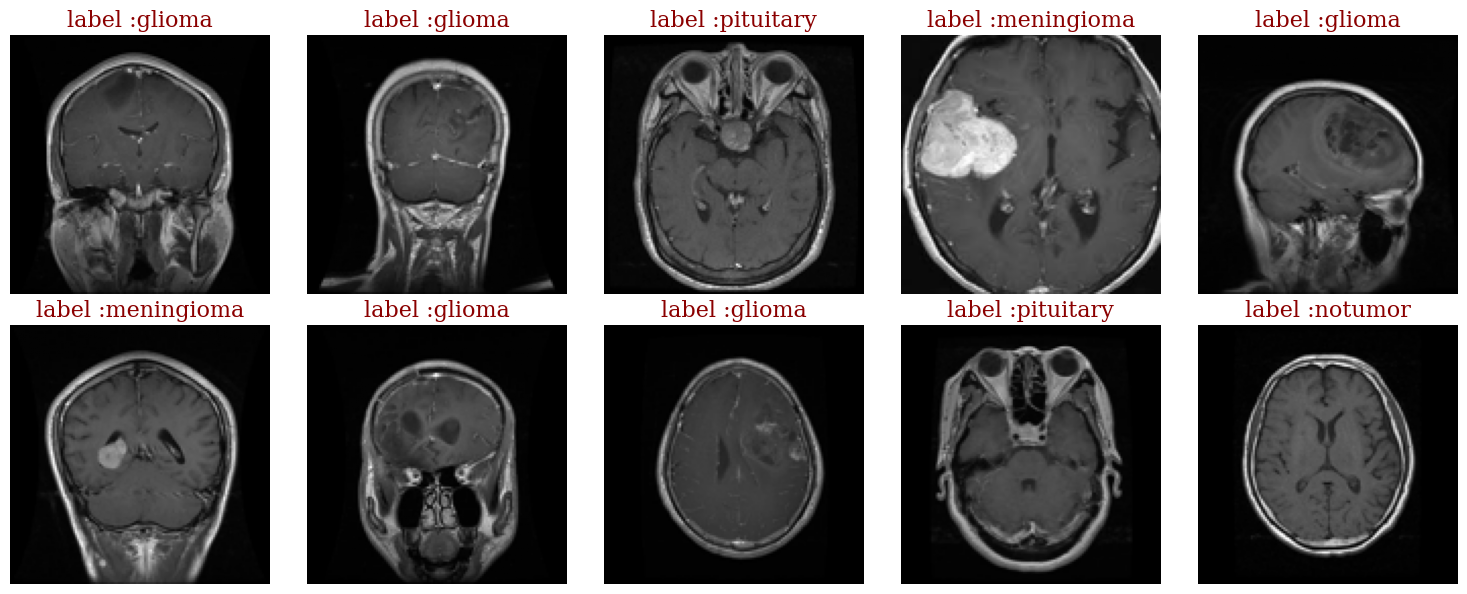

In [ ]:
import random # Import libraries for random selection and plotting
import matplotlib.pyplot as plt

random_indices = random.sample(range(len(train_paths)), 10) # Randomly select 10 indices from the training dataset
random_indices

# Create a figure with the desired figsize
fig = plt.figure(figsize=(15, 6)) # Create subplots for displaying images
# Create subplots within the figure
axes = fig.subplots(2, 5)
axes = axes.ravel()

# Define the font properties you want to use
font = {'family': 'serif', 'color':  'darkred', 'weight': 'normal', 'size': 16} # Define the font dictionary here

for i, idx in enumerate(random_indices): # Loop through each randomly selected index
    img_path = train_paths[idx]  # Get the image path
    img = Image.open(img_path)  # Open the image
    img = img.resize((128, 128))  # Resize the image to 128x128 pixels
    axes[i].imshow(img, cmap='gray') # Display the image in grayscale
    axes[i].set_title(f"Label: {train_labels[idx]}") # Set the title with the label and apply font settings
    axes[i].axis('off')    # Remove axis ticks
    axes[i].set_title(f"label :{train_labels[idx]}", fontdict=font) # Pass the font dictionary to fontdict


plt.tight_layout() # Adjust layout to prevent overlapping
plt.show() # Show the plotted images

In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

In [ ]:
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1512s 5s/step - loss: 0.6396 - sparse_categorical_accuracy: 0.7436
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1461s 5s/step - loss: 0.2434 - sparse_categorical_accuracy: 0.9038
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1433s 5s/step - loss: 0.1603 - sparse_categorical_accuracy: 0.9416
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1426s 5s/step - loss: 0.0976 - sparse_categorical_accuracy: 0.9661
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1426s 5s/step - loss: 0.0744 - sparse_categorical_accuracy: 0.9703


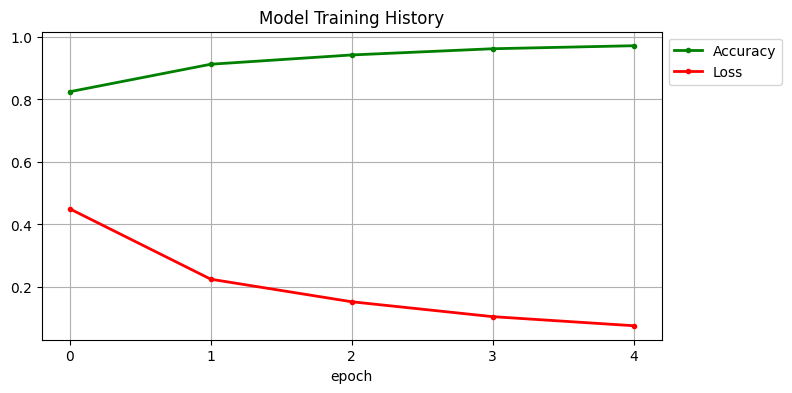

In [ ]:
plt.figure(figsize=(8,4)) # Create a new figure with specific size
plt.grid(True) # Add grid lines to the plot for better readability
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2) # Plot the training accuracy over epochs
plt.plot(history.history['loss'], '.r-', linewidth=2) # Plot the training loss over epochs
plt.title('Model Training History') # Set the title of the plot
plt.xlabel('epoch') # Label the x-axis
plt.xticks([x for x in range(epochs)]) # Set x-ticks for each epoch
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1)) # Add a legend outside the top-left corner of the plot
plt.show() # Display the final plot

In [ ]:
import matplotlib.pyplot as plt # Import library for plotting graphs and images
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc # Import evaluation metrics from sklearn
import seaborn as sns # Import seaborn for enhanced data visualization (heatmaps, etc.)
from sklearn.preprocessing import label_binarize # Import function to binarize labels for multi-class ROC analysis
from tensorflow.keras.models import load_model # Import function to load a saved Keras model
import numpy as np # Import numpy for numerical operations

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 268s 7s/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       300
           1       0.91      0.96      0.93       300
           2       0.96      1.00      0.98       405
           3       0.96      0.88      0.92       306

    accuracy                           0.96      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311



Confusion Matrix:
[[292   5   1   2]
 [  0 287   3  10]
 [  0   0 405   0]
 [  0  24  13 269]]


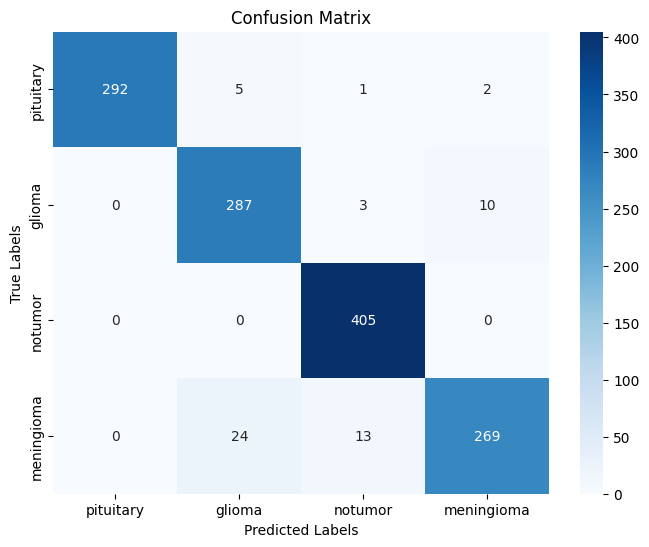

In [ ]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

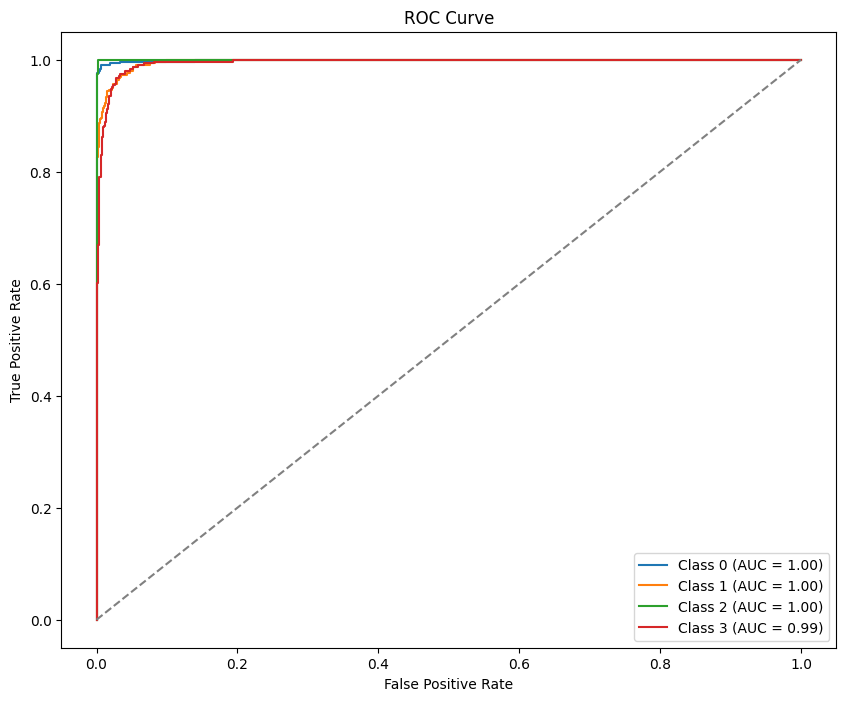

In [ ]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve") # Set the title of the plot
plt.xlabel("False Positive Rate") # Label the x-axis
plt.ylabel("True Positive Rate") # Label the y-axis
plt.legend(loc="lower right") # Display the legend in the lower right corner
plt.show() # Show the final plot

In [ ]:
model.save('model.h5')

In [ ]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


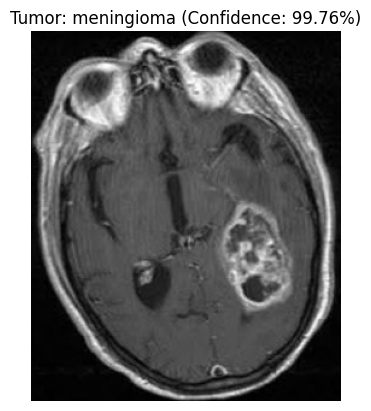

In [ ]:
# Example usage
image_path = '/content/drive/MyDrive/MRI images/archive-2/Testing/meningioma/Te-meTr_0001.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


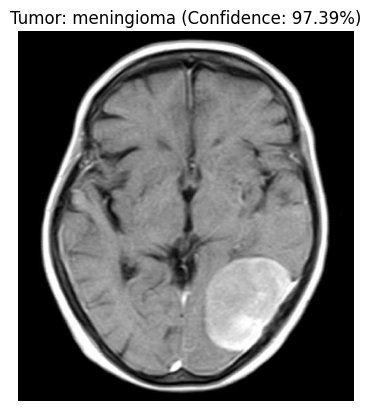

In [ ]:
# Example usage
image_path = '/content/drive/MyDrive/MRI images/archive-2/Testing/meningioma/Te-meTr_0004.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


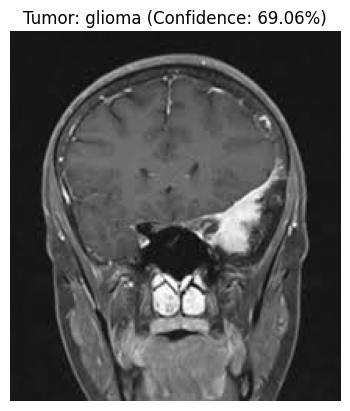

In [ ]:
# Example usage
image_path = '/content/drive/MyDrive/MRI images/archive-2/Testing/meningioma/Te-meTr_0003.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


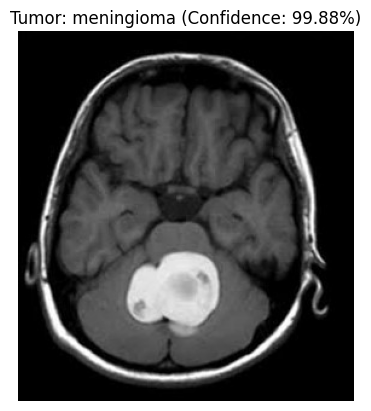

In [ ]:
# Example usage
image_path = '/content/drive/MyDrive/MRI images/archive-2/Testing/meningioma/Te-me_0029.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)